<a href="https://colab.research.google.com/github/bibekebib/Major-project-raw-files/blob/main/Custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/dataset'

In [3]:
from glob import glob
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
df = pd.read_csv('/content/drive/MyDrive/dataset/image_path.csv')

In [6]:
df.head()

,Unnamed: 0,path,label
0,0,/content/drive/MyDrive/TestFolder/vriksh-deepa...,1
1,1,/content/drive/MyDrive/TestFolder/vriksh-deepa...,1
2,2,/content/drive/MyDrive/TestFolder/vriksh-deepa...,1
3,3,/content/drive/MyDrive/TestFolder/vriksh-deepa...,1
4,4,/content/drive/MyDrive/TestFolder/vriksh-deepa...,1


In [75]:

class CustomDataset(Dataset):
  def __init__(self, df, transforms=False):  
    self.imgpath = df.path 
    self.label = df.label

  def __len__(self):
    return len(self.imgpath)
  
  def __getitem__(self, ix):
    f = self.imgpath[ix]
    target = (self.label[ix])
    im = cv2.imread(f)[:,:,::-1]
    im - cv2.resize(im, (224,224))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return torch.tensor(im/255).to(device).float(), torch.tensor(target).long().to(device)
 


In [76]:
data = CustomDataset(df)

In [77]:
im, label = data[100]

tensor(1, device='cuda:0')

torch.Size([224, 224])

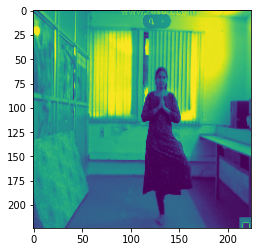

In [82]:
plt.imshow(im.cpu())
print(label)
print(im.shape)

In [83]:
import torch.nn as nn

def conv_layer(ni, no, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

In [102]:
def get_model():
  model = nn.Sequential(
      conv_layer(1,8,2),
      conv_layer(8,16, 2),
      nn.Flatten(),
      nn.Linear(48400,10),
      nn.Sigmoid(),
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [103]:

model, loss_fn, optimizer = get_model()
from torchsummary import summary
summary(model, (1, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 223, 223]              40
              ReLU-2          [-1, 8, 223, 223]               0
       BatchNorm2d-3          [-1, 8, 223, 223]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 16, 110, 110]             528
              ReLU-6         [-1, 16, 110, 110]               0
       BatchNorm2d-7         [-1, 16, 110, 110]              32
         MaxPool2d-8           [-1, 16, 55, 55]               0
           Flatten-9                [-1, 48400]               0
           Linear-10                   [-1, 10]         484,010
          Sigmoid-11                   [-1, 10]               0
Total params: 484,626
Trainable params: 484,626
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/

In [104]:
def get_data():
  train = CustomDataset(df)
  trn_dl = DataLoader(train, batch_size=32,shuffle=True, drop_last=True)
  return trn_dl

In [105]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [106]:
@torch.no_grad()
def accuracy(x, y, model):
  prediction = model(x)
  is_correct = (prediction > 0.5) ==1
  return is_correct.cpu().numpy().tolist()

In [107]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [109]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        x = x.reshape(32,1, 224,224)
  
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        x = x.reshape(32, 1, 224, 224)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)



    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)


0

1

2

3

4

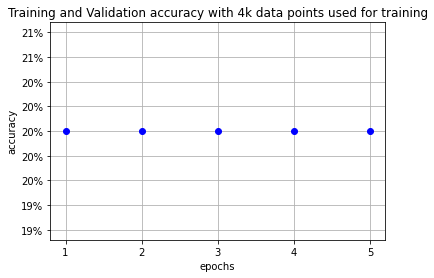

In [110]:
epochs = np.arange(5) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
# plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation accuracy with 4k data points used for training')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid('off')
plt.show()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   12050 MB |   12904 MB |   19470 MB |    7419 MB |
|       from large pool |   12049 MB |   12904 MB |   19382 MB |    7333 MB |
|       from small pool |       0 MB |      86 MB |      87 MB |      86 MB |
|---------------------------------------------------------------------------|
| Active memory         |   12050 MB |   12904 MB |   19470 MB |    7419 MB |
|       from large pool |   12049 MB |   12904 MB |   19382 MB |